# Machine Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Mattias Aareleid|mattyonaize|Mattias Aareleid|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Feature Engineering](#feature-engineering)
- [Modeling](#modeling)
    
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

## Data Overview

In [4]:
labeled_path = r"labeled"
unlabeled_path = r"unlabeled"

labeled_files = [os.path.join(labeled_path, file) for file in os.listdir(labeled_path)]
unlabeled_files = [os.path.join(unlabeled_path, file) for file in os.listdir(unlabeled_path)]

## Feature Engineering

In [5]:
def audio_features(files):
    features_list = []

    for file in files:
        # Check if it's an audio file (you can expand the condition for specific extensions)
        if file.endswith(('.wav', '.mp3', '.flac')):
            try:
                # Load the audio file
                y, sr = librosa.load(file, sr=None)  # Use original sampling rate

                # Extract features
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # MFCCs
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Chroma features
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Spectral contrast
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Spectral Bandwidth
                spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral Centroid
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)  # Roll-Off Frequency (85%)

                # Aggregate features (mean and standard deviation)
                feature_vector = {
                    'file_name': os.path.basename(file),
                    'mfccs_mean': np.mean(mfccs, axis=1).tolist(),
                    'mfccs_std': np.std(mfccs, axis=1).tolist(),
                    'chroma_mean': np.mean(chroma, axis=1).tolist(),
                    'spectral_contrast_mean': np.mean(spectral_contrast, axis=1).tolist(),
                    'spectral_bandwidth_mean': np.mean(spectral_bandwidth).tolist(),
                    'spectral_bandwidth_std': np.std(spectral_bandwidth).tolist(),
                    'spectral_centroid_mean': np.mean(spectral_centroid).tolist(),
                    'spectral_centroid_std': np.std(spectral_centroid).tolist(),
                    'rolloff_mean': np.mean(rolloff).tolist(),
                    'rolloff_std': np.std(rolloff).tolist(),
                }

                features_list.append(feature_vector)

            except Exception as e:
                print(f"Error processing {file}: {e}")
    return features_list


In [6]:
labeled_fl = audio_features(labeled_files)
unlabeled_fl = audio_features(unlabeled_files)

In [7]:
labeled_df = pd.DataFrame(labeled_fl).set_index('file_name')
unlabeled_df = pd.DataFrame(unlabeled_fl).set_index('file_name')

In [9]:
# Expand 'mfccs_mean' into multiple columns
mfccs_mean_df = pd.DataFrame(labeled_df['mfccs_mean'].tolist(), index=labeled_df.index, 
                             columns=[f'mfccs_mean_{i}' for i in range(13)])

# Expand 'mfccs_std' into multiple columns
mfccs_std_df = pd.DataFrame(labeled_df['mfccs_std'].tolist(), index=labeled_df.index, 
                            columns=[f'mfccs_std_{i}' for i in range(13)])

# Expand 'chroma_mean' into multiple columns
chroma_mean_df = pd.DataFrame(labeled_df['chroma_mean'].tolist(), index=labeled_df.index, 
                              columns=[f'chroma_mean_{i}' for i in range(12)])

# Expand 'spectral_contrast_mean' into multiple columns
spectral_contrast_mean_df = pd.DataFrame(labeled_df['spectral_contrast_mean'].tolist(), 
                                         index=labeled_df.index, 
                                         columns=[f'spectral_contrast_mean_{i}' for i in range(7)])

# Expand 'spectral_bandwidth_mean' and 'spectral_bandwidth_std'
spectral_bandwidth_mean_df = pd.DataFrame(labeled_df['spectral_bandwidth_mean'].tolist(), index=labeled_df.index, 
                                          columns=['spectral_bandwidth_mean'])
spectral_bandwidth_std_df = pd.DataFrame(labeled_df['spectral_bandwidth_std'].tolist(), index=labeled_df.index, 
                                         columns=['spectral_bandwidth_std'])

# Expand 'spectral_centroid_mean' and 'spectral_centroid_std'
spectral_centroid_mean_df = pd.DataFrame(labeled_df['spectral_centroid_mean'].tolist(), index=labeled_df.index, 
                                         columns=['spectral_centroid_mean'])
spectral_centroid_std_df = pd.DataFrame(labeled_df['spectral_centroid_std'].tolist(), index=labeled_df.index, 
                                        columns=['spectral_centroid_std'])

# Expand 'rolloff_mean' and 'rolloff_std'
rolloff_mean_df = pd.DataFrame(labeled_df['rolloff_mean'].tolist(), index=labeled_df.index, 
                               columns=['rolloff_mean'])
rolloff_std_df = pd.DataFrame(labeled_df['rolloff_std'].tolist(), index=labeled_df.index, 
                              columns=['rolloff_std'])

# Combine all expanded columns into one DataFrame
expanded_features_df = pd.concat([
    mfccs_mean_df, mfccs_std_df, chroma_mean_df, spectral_contrast_mean_df,
    spectral_bandwidth_mean_df, spectral_bandwidth_std_df,
    spectral_centroid_mean_df, spectral_centroid_std_df,
    rolloff_mean_df, rolloff_std_df
], axis=1)

# Final labeled DataFrame
final_labeled_df = pd.concat([labeled_df.drop(columns=[
    'mfccs_mean', 'mfccs_std', 'chroma_mean', 'spectral_contrast_mean',
    'spectral_bandwidth_mean', 'spectral_bandwidth_std',
    'spectral_centroid_mean', 'spectral_centroid_std',
    'rolloff_mean', 'rolloff_std'
]), expanded_features_df], axis=1)

display(final_labeled_df.head())

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00002.wav,-298.756134,112.076279,6.488818,28.389170,-6.770987,16.645588,-11.807551,12.744363,-8.340971,13.893223,-4.237726,2.317613,-4.329583,39.433178,19.755568,17.913633,10.284375,10.052850,7.867815,9.057553,6.990480,6.884763,8.017497,10.577836,11.242255,10.993814,0.117655,0.133911,0.220483,0.188410,0.168177,0.193637,0.130628,0.203946,0.364396,0.287584,0.224478,0.185700,19.667917,20.515668,26.072390,25.745788,23.396068,19.541724,34.600593,1920.270843,352.469828,1451.862124,428.935223,3047.431199,1357.209937
m00039.wav,-169.153351,110.459999,-8.576200,43.884247,0.274970,26.637419,-14.368152,13.034431,-11.149249,8.130109,-7.692966,10.910651,-8.175924,76.763023,34.862965,22.223734,18.106983,15.671126,11.999970,16.115822,11.386265,12.897258,10.966521,10.147038,8.840706,9.594254,0.412044,0.333314,0.389580,0.370359,0.308951,0.386791,0.288708,0.329985,0.243529,0.297682,0.422818,0.401892,19.964829,17.050832,21.109923,19.301231,20.553355,18.597363,38.304349,2019.300256,442.196748,1811.410394,809.772584,3854.851374,1697.237331
m00041.wav,-18.845390,71.325661,-3.766896,-1.408727,0.705463,-1.058955,-1.054825,-0.247421,0.625723,0.427043,-1.503742,-1.076155,2.419871,58.091900,22.259552,16.869591,15.726175,11.130232,11.935092,9.296320,9.794338,10.930790,8.955583,9.219586,8.444303,6.864933,0.412797,0.537429,0.301002,0.379488,0.269635,0.380168,0.264904,0.303026,0.473597,0.332073,0.445475,0.293710,17.233862,14.865518,18.241217,18.563320,19.586908,17.007064,15.156099,2992.010638,346.836989,3110.898196,779.418889,6744.988603,1477.610861
m00072.wav,-69.630653,83.072273,-16.599928,0.118371,7.420607,0.770008,1.337478,4.695798,-1.416824,3.319435,-2.878265,-8.202150,-5.767511,48.211746,20.987648,17.476086,13.754786,10.223347,10.034362,8.661865,7.707412,8.616606,8.162474,7.835617,8.075592,6.921044,0.286717,0.369671,0.274070,0.371768,0.311118,0.487252,0.551675,0.375336,0.508560,0.282717,0.376277,0.277690,29.752017,16.141935,18.926104,19.113687,19.466281,17.548978,15.208348,2709.897108,360.419232,2624.814629,585.287392,5605.777240,1452.165395
m00096.wav,-91.983772,87.640099,-2.066796,34.278149,-18.124571,19.345659,-14.665756,17.112078,-15.336202,17.028185,-13.534051,11.835089,-9.814680,73.534546,22.862232,24.729223,15.726049,15.136001,15.799397,11.942945,12.134771,9.222271,11.038783,12.206540,11.016730,11.804406,0.432902,0.321649,0.366385,0.344440,0.321556,0.335174,0.332990,0.352914,0.269636,0.244928,0.239062,0.318006,16.843315,15.728975,19.023666,19.995101,19.370804,18.633169,43.553926,2485.524548,368.525304,2549.269757,695.078336,5583.144894,1395.390545


In [12]:
numeric_features = final_labeled_df.select_dtypes(include=[np.number])


In [14]:
sns.set(style="darkgrid")

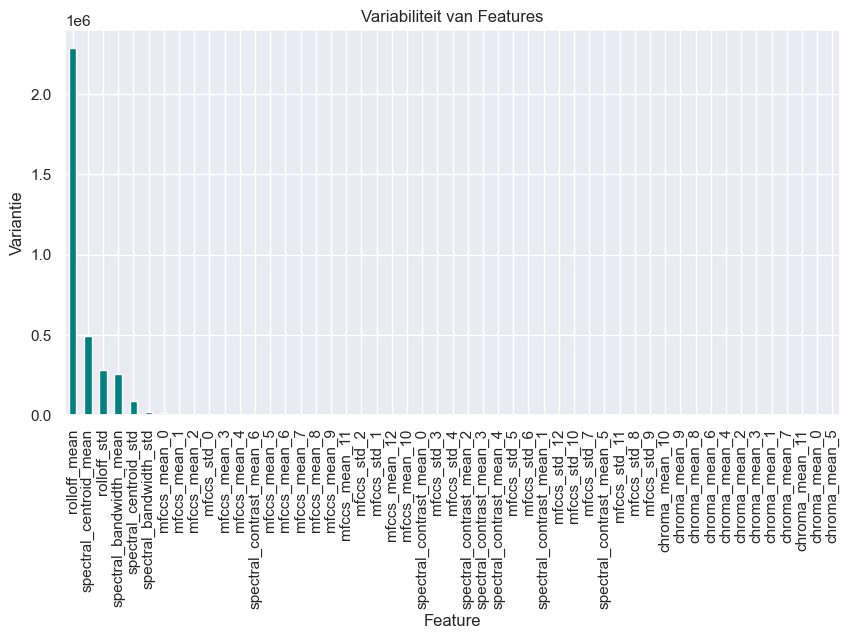

In [15]:
# Variabiliteit berekenen
feature_variability = numeric_features.var().sort_values(ascending=False)

# Plot de variabiliteit
plt.figure(figsize=(10, 5))
feature_variability.plot(kind='bar', color='teal')
plt.title('Variabiliteit van Features')
plt.ylabel('Variantie')
plt.xlabel('Feature')
plt.show()

## Modeling

## Results

## Conclusion & Advice

## Sources